# Import needed modules and useful functions

In [1]:
#-- useful python script for training the DeepTICA cvs --#
from utils import *

#-- to not visualize warnings --#
import warnings
warnings.filterwarnings('ignore')

# Simulation parameters 

In [2]:
kb=0.008314
#-- SIMULATION PARAMETERS --#
sim_parameters = {
    'temp':300, 
    'beta': 1./(300*kb),
    'kbt': None,
    #-- parameters to compute the fes --#
    'blocks':2,
    'bandwidth': 0.02,
    'plot_max_fes' :70,
}
#--------------------------------------#

# Prepare input files for plumed

In [3]:
from_time = 15000
descriptor_filter = 'd'

colvar = load_dataframe("Luigi_deep/data/COLVAR")
descr = load_dataframe("Luigi_deep/data/COLVAR_DRIVER")

# Concatenate without duplicates
colvar = pd.concat([colvar, descr[[i for i in descr.columns if (i not in colvar.columns)]]], axis=1)

print(np.max(colvar["opes.bias"]))

# qui luigi non prendi i primi dati
#colvar = colvar[ colvar['time']>from_time ]

print(colvar.head())

1.7288400000000002
   time      phi      psi      ene  opes.bias      d1        d2        d3  \
0   0.0 -2.85623  2.79199 -37.6167        0.0  0.1522  0.236987  0.247849   
1   1.0 -2.82861  2.82895 -38.0432        0.0  0.1522  0.245155  0.238748   
2   2.0 -2.25079  2.88494 -38.5001        0.0  0.1522  0.235771  0.248807   
3   3.0 -2.17941  2.46362 -37.9637        0.0  0.1522  0.241939  0.234867   
4   4.0 -2.59868  2.59588 -43.4282        0.0  0.1522  0.236894  0.240697   

         d4        d5  ...       d36       d37       d38       d39     d40  \
0  0.382973  0.458505  ...  0.248609  0.322104  0.304661  0.442144  0.1229   
1  0.379865  0.448632  ...  0.254401  0.327502  0.309833  0.445151  0.1229   
2  0.384648  0.478494  ...  0.240124  0.333106  0.297949  0.419448  0.1229   
3  0.375998  0.458025  ...  0.256054  0.320653  0.330439  0.463237  0.1229   
4  0.378112  0.452084  ...  0.250334  0.324561  0.324644  0.454080  0.1229   

      d41       d42       d43       d44     d45  

<AxesSubplot:xlabel='time', ylabel='opes.bias'>

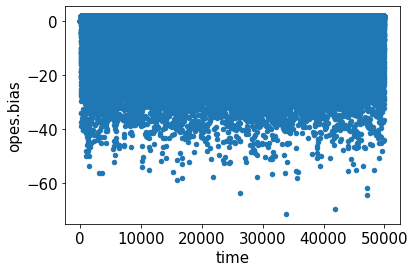

In [4]:
colvar.plot.scatter(x="time",y="opes.bias")

Text(0, 0.5, '$\\psi$')

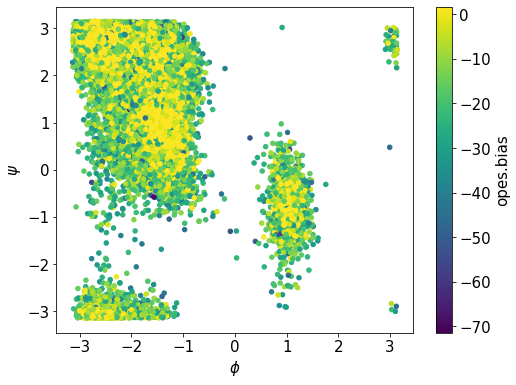

In [5]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
colvar.plot.scatter(y="psi",x="phi",c="opes.bias",cmap="viridis",ax=ax)
ax.set_xlabel(r"$\phi$")
ax.set_ylabel(r"$\psi$")

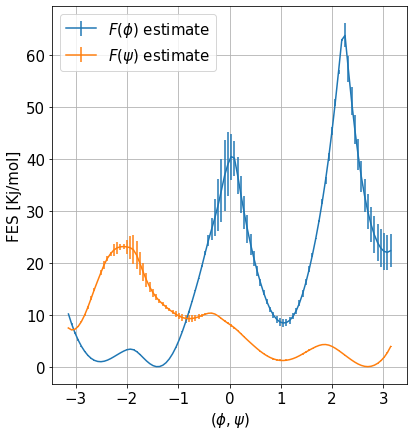

In [6]:
#-- estimation of Free Energy Surface --#
s = colvar.filter(regex="^p").to_numpy()
logweight=( colvar["opes.bias"].to_numpy()-max(colvar["opes.bias"].to_numpy()) )*sim_parameters["beta"]

fig, ax = plt.subplots(figsize=(6,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        temp=sim_parameters["temp"],
                                        kbt=sim_parameters["kbt"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend([r"$F(\phi)$ estimate",r"$F(\psi)$ estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(\phi,\psi)$")
ax.set_ylabel("FES [Kj/mol]")

plt.show()

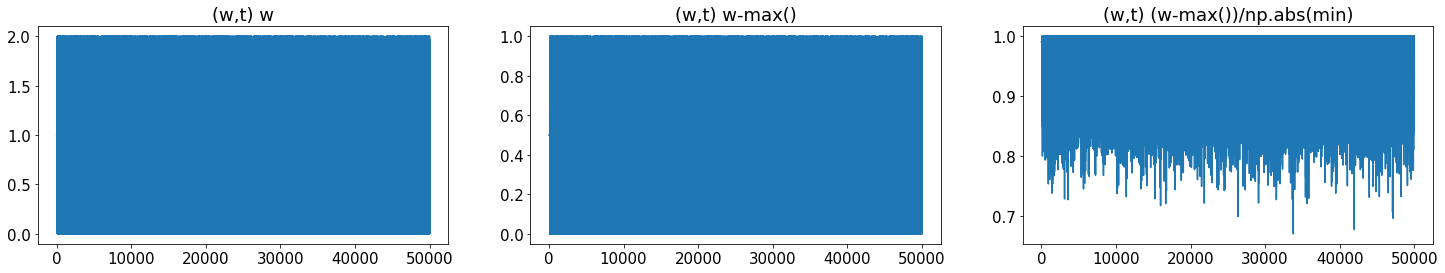

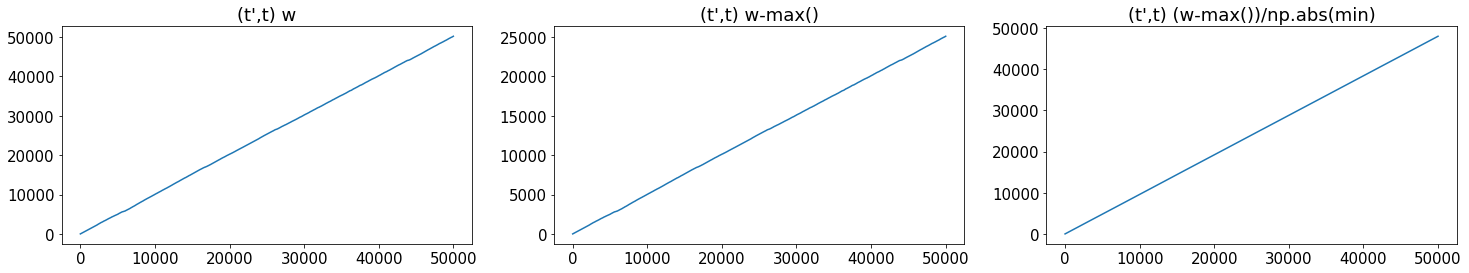

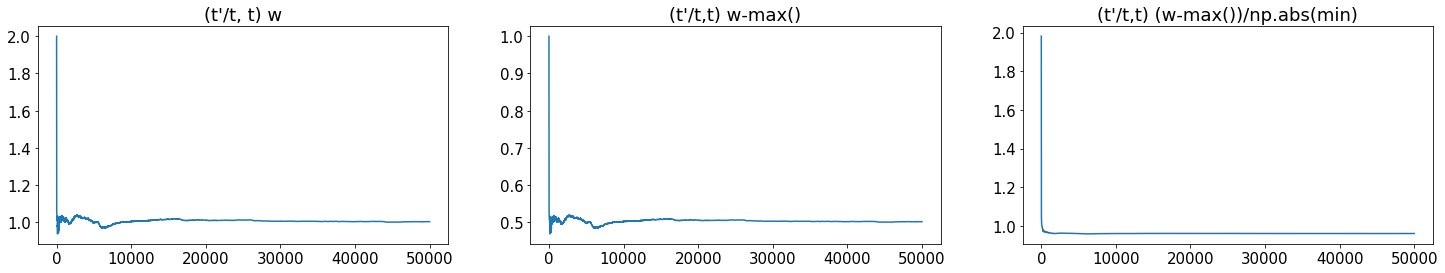

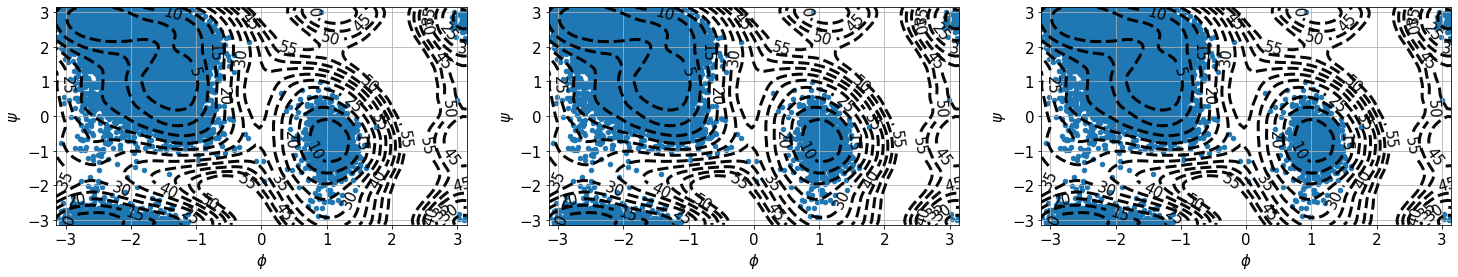

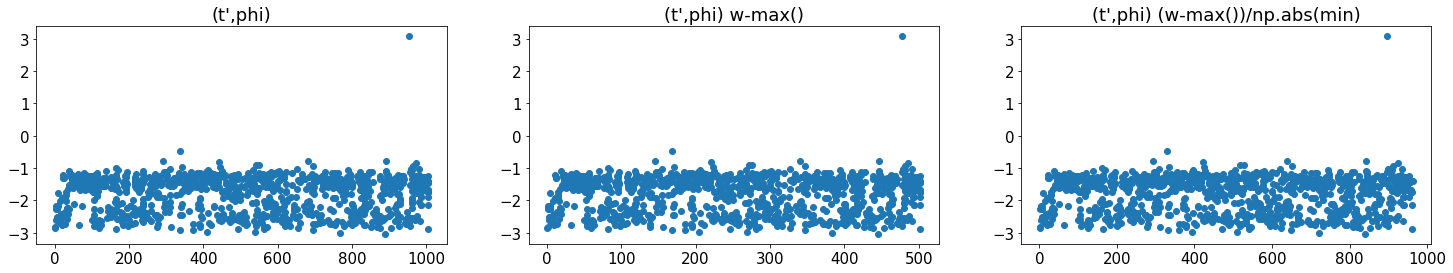

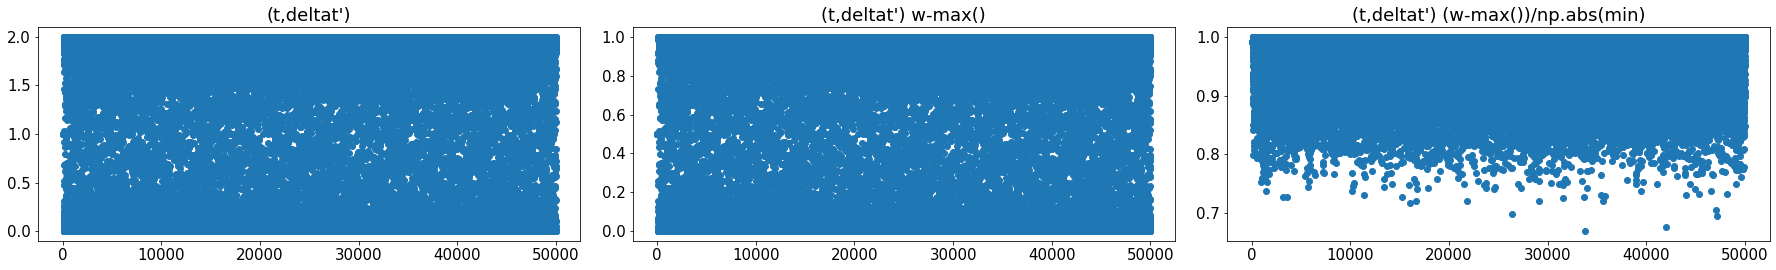

In [7]:
#''' compare different set up for rescaled time
fig,axs1 = plt.subplots(1,3,figsize=(25,4))
fig,axs2 = plt.subplots(1,3,figsize=(25,4))
fig,axs3 = plt.subplots(1,3,figsize=(25,4))
fig,axs4 = plt.subplots(1,3,figsize=(25,4))
fig,axs5 = plt.subplots(1,3,figsize=(25,4))
fig,axs6 = plt.subplots(1,3,figsize=(25,4))
    
X = colvar.filter(regex='^d[^a-z]').values
# rescaled as must be
logweight = colvar["opes.bias"].to_numpy()*sim_parameters["beta"]
t = colvar['time'].values
dt = t[1]-t[0]
tprime = dt * np.cumsum(np.exp(logweight))
axs1[0].plot(t,np.exp(logweight))
axs1[0].set_title("(w,t) w")
axs2[0].plot(t,tprime)
axs2[0].set_title("(t',t) w")
axs3[0].plot(t[1:],tprime[1:]/t[1:])
axs3[0].set_title("(t'/t, t) w")
axs5[0].scatter(tprime[:1000],colvar["phi"].to_numpy()[:1000])
axs5[0].set_title("(t',phi)")
deltatprime = [tprime[i+1]-tprime[i] for i in range(len(tprime)-1)]
axs6[0].scatter(t[1:],deltatprime)
axs6[0].set_title("(t,deltat')")
# rescaled as Michele wants
logweight -= max(logweight)
tprime = dt * np.cumsum(np.exp(logweight))
axs1[1].plot(t,np.exp(logweight))
axs1[1].set_title("(w,t) w-max()")
axs2[1].plot(t,tprime)
axs2[1].set_title("(t',t) w-max()")
axs3[1].plot(t[1:],tprime[1:]/t[1:])
axs3[1].set_title("(t'/t,t) w-max()")
axs5[1].scatter(tprime[:1000],colvar["phi"].to_numpy()[:1000])
axs5[1].set_title("(t',phi) w-max()")
deltatprime = [tprime[i+1]-tprime[i] for i in range(len(tprime)-1)]
axs6[1].scatter(t[1:],deltatprime)
axs6[1].set_title("(t,deltat') w-max()")
# rescaled as I want
logweight = colvar["opes.bias"].to_numpy()-max(colvar["opes.bias"].to_numpy())
logweight /= np.abs(np.min(logweight))
logweight *= sim_parameters["beta"]
tprime = dt * np.cumsum(np.exp(logweight))
axs1[2].plot(t,np.exp(logweight))
axs1[2].set_title("(w,t) (w-max())/np.abs(min)")
axs2[2].plot(t,tprime)
axs2[2].set_title("(t',t) (w-max())/np.abs(min)")
axs3[2].plot(t[1:],tprime[1:]/t[1:])
axs3[2].set_title("(t'/t,t) (w-max())/np.abs(min)")
axs5[2].scatter(tprime[:1000],colvar["phi"].to_numpy()[:1000])
axs5[2].set_title("(t',phi) (w-max())/np.abs(min)")
deltatprime = [tprime[i+1]-tprime[i] for i in range(len(tprime)-1)]
axs6[2].scatter(t[1:],deltatprime)
axs6[2].set_title("(t,deltat') (w-max())/np.abs(min)")
#-- trajectories in phi / psi --#

fes = np.loadtxt("angles/fes.txt",delimiter=" ")
grid0 = np.loadtxt("angles/grid0.txt",delimiter=" ")
grid1 = np.loadtxt("angles/grid1.txt",delimiter=" ")
bounds = np.arange(0, 60, 5.)
for i in range(3):
    colvar.plot.scatter(y="psi",x="phi",ax=axs4[i])
    c = axs4[i].contour(grid0, grid1, fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
        norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
    )
    c.clabel()
    axs4[i].grid()
    axs4[i].set_xlabel(r"$\phi$")
    axs4[i].set_ylabel(r"$\psi$")
plt.tight_layout()
#'''

In [8]:
'''
fig,axs1 = plt.subplots(1,3,figsize=(20,4))
data = load_dataframe(folder+"COLVAR")
t = data['time'].values
X = data.filter(regex='^d[^a-z]').values
logweight = data["opes.bias"].to_numpy()*sim_parameters["beta"]
dt = t[1]-t[0]
tprime = dt * np.cumsum(np.exp(logweight))
x = data["phi"].values
#-- without minus max --#
autocorr = np.empty(0)
N = 100
lags = np.linspace(0,10,N)
for lag in lags:
    res = my_autocorrelation_python(x,lag=lag,weight=np.exp(logweight),time=t, tprime=tprime)
    autocorr = np.append(autocorr,res)
axs1[0].plot(lags,autocorr)
axs1[0].set_title("(t,w)")
#-- with minus max --#
autocorr = np.empty(0)
logweight -= max(logweight)
tprime = dt * np.cumsum(np.exp(logweight))
for lag in lags:
    res = my_autocorrelation_python(x,lag=lag,weight=np.exp(logweight),time=t, tprime=tprime)
    autocorr = np.append(autocorr,res)
axs1[1].plot(lags,autocorr)
axs1[1].set_title("(t,w) w-max() ")
#-- with minus max and / np.abs(min)--#
logweight = data["opes.bias"].to_numpy()-max(data["opes.bias"].to_numpy())
logweight /= np.abs(np.min(logweight))
autocorr = np.empty(0)
logweight *= sim_parameters["beta"]
tprime = dt * np.cumsum(np.exp(logweight))
for lag in lags:
    res = my_autocorrelation_python(x,lag=lag,weight=np.exp(logweight),time=t, tprime=tprime)
    autocorr = np.append(autocorr,res)
axs1[2].plot(lags,autocorr)
axs1[2].set_title("(t,w) (w-max())/np.abs(min)")
'''

'\nfig,axs1 = plt.subplots(1,3,figsize=(20,4))\ndata = load_dataframe(folder+"COLVAR")\nt = data[\'time\'].values\nX = data.filter(regex=\'^d[^a-z]\').values\nlogweight = data["opes.bias"].to_numpy()*sim_parameters["beta"]\ndt = t[1]-t[0]\ntprime = dt * np.cumsum(np.exp(logweight))\nx = data["phi"].values\n#-- without minus max --#\nautocorr = np.empty(0)\nN = 100\nlags = np.linspace(0,10,N)\nfor lag in lags:\n    res = my_autocorrelation_python(x,lag=lag,weight=np.exp(logweight),time=t, tprime=tprime)\n    autocorr = np.append(autocorr,res)\naxs1[0].plot(lags,autocorr)\naxs1[0].set_title("(t,w)")\n#-- with minus max --#\nautocorr = np.empty(0)\nlogweight -= max(logweight)\ntprime = dt * np.cumsum(np.exp(logweight))\nfor lag in lags:\n    res = my_autocorrelation_python(x,lag=lag,weight=np.exp(logweight),time=t, tprime=tprime)\n    autocorr = np.append(autocorr,res)\naxs1[1].plot(lags,autocorr)\naxs1[1].set_title("(t,w) w-max() ")\n#-- with minus max and / np.abs(min)--#\nlogweight = d

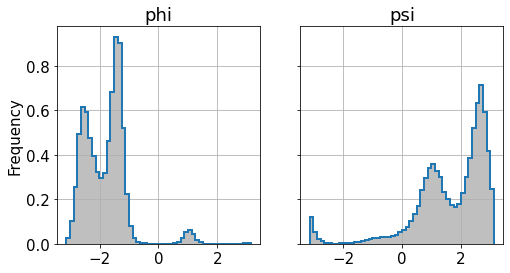

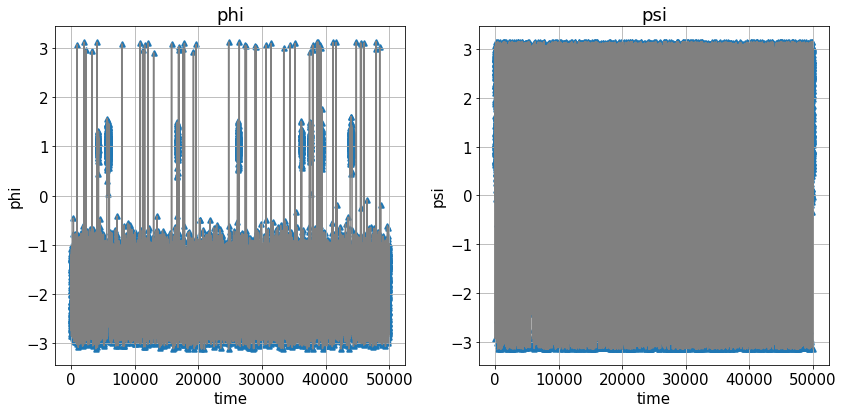

In [9]:
descriptors_names = colvar.filter(regex='^p').columns.values

fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)

for ax,desc in zip(axs.flatten(),descriptors_names):
    colvar[desc].plot.hist(bins=50,alpha=1,ax=ax,legend=False,grid=True,histtype='step',linewidth=2,density=True)
    colvar[desc].plot.hist(bins=50,alpha=0.5,ax=ax,legend=False,grid=True,color="grey",density=True)
    ax.set_title(desc)

fig,axs = plt.subplots(1,2,figsize=(12,6))

for ax,desc in zip(axs.flatten(),descriptors_names):
    colvar[::1].plot.scatter(x="time",y=desc,alpha=1,ax=ax,legend=False,grid=True,linewidth=2,marker="^")
    colvar[::1].plot.line(x="time",y=desc,alpha=1,ax=ax,legend=False,grid=True,color="grey")
    ax.set_title(desc)

plt.tight_layout()

## Deep TICA Analysis  

In [10]:
size = len(colvar) # total sampled points for each simulation
min_lag,max_lag = 1,5 
n = 1 # how many lag times between min and max lag
lags = np.linspace(min_lag,max_lag,n) #-- how many batches for the train and valid set of a single simulation
print(lags)
shuffle = False # if shuffle the data between batches
#-- train_datasets and valid_datasets list, it will be filled with new data every iteration
train_datasets = []
valid_datasets = []
# torch seed 
torch.manual_seed(21)

descriptors_names = colvar.filter(regex='^d[^a-z]').columns.values
print(len(descriptors_names))
#-- TRAINING PARAMETERS --#
n_output = 2 # 2 non linear combination of the descriptors  
n_input = len(descriptors_names) 
train_parameters = {
              'descriptors': '^d[^a-z]', # can change during simulation
              'nodes':[n_input,30,30,n_output],
              'activ_type': 'tanh',#'relu','selu','tanh'
              'lag_time':10, 
              'loss_type': 'sum', 
              'n_eig': n_output,
              'trainsize':0.75, 
              'lrate':1e-3,
              'l2_reg':0.,
              'num_epochs':500,
              'batchsize': -1, #---> è da fare sul train loder and valid loader
              'es_patience':1000,
              'es_consecutive':True,
              'standardize_outputs':True,
              'standardize_inputs': True,
              'log_every':50,
              }

# how many data in single batch, batchsize
n_train = int( size*train_parameters["trainsize"] )
n_valid = int( size*(1-train_parameters["trainsize"])-int(10*max_lag) )
print("training samples: ",n_train, "\t validation samples", n_valid)

# DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

t = colvar['time'].values
X = colvar[descriptors_names].values

[1.]
45
training samples:  37500 	 validation samples 12450


In [11]:
# evaluate tprime
logweight = colvar["opes.bias"].to_numpy()*sim_parameters["beta"]
dt = t[1]-t[0]
tprime = dt * np.cumsum(np.exp(logweight))
print(tprime)

[1.00000000e+00 2.00000000e+00 3.00000000e+00 ... 5.02082044e+04
 5.02082122e+04 5.02098827e+04]


In [12]:
tprime = t
logweight = None

train_datasets = []
valid_datasets = []
# create time lagged dataset with different lag times
for lag in lags:
    #random split
    # TensorDataset (x_t,x_lag,w_t,w_lag)
    dataset = create_time_lagged_dataset(X,t=t,lag_time=np.round(lag,3),tprime=tprime,logweights=logweight,interval=[0,n_train+n_valid])
    train_data, valid_data = random_split(dataset,[n_train,n_valid])
    train_datasets.append(train_data)
    valid_datasets.append(valid_data)

train_loader = FastTensorDataLoader(train_datasets, batch_size=n_train,shuffle=shuffle)
valid_loader = FastTensorDataLoader(valid_datasets, batch_size=n_valid,shuffle=shuffle)

#-- TRAIN --#
# MODEL
model = DeepTICA_CV(train_parameters['nodes'],activation=train_parameters['activ_type'],gaussian_random_initialization=True)
model.to(device)
# OPTIMIZER (Adam)
opt = torch.optim.Adam(model.parameters(), lr=train_parameters['lrate'], weight_decay=train_parameters['l2_reg'])
# lrscheduler
#model.set_LRScheduler(opt,min_lr=5e-5)
model.set_optimizer(opt)
if valid_loader is not None:
    # EarlyStopping
    model.set_earlystopping(patience=train_parameters['es_patience'],
                            min_delta=0.005,consecutive=train_parameters['es_consecutive'], save_best_model=True, log=False) 
# TRAIN
model.fit(train_loader=train_loader,valid_loader=valid_loader,
    standardize_inputs=train_parameters['standardize_inputs'],
    standardize_outputs=train_parameters['standardize_outputs'],
    loss_type=train_parameters['loss_type'],
    n_eig=train_parameters['n_eig'],
    nepochs=train_parameters['num_epochs'],
    info=False, log_every=train_parameters['log_every'])
#-- move the model back to cpu for convenience --#
model.to('cpu')

[Warning] Normalization: the following features have a range of values < 1e-6: tensor([[ 0],
        [ 9],
        [10],
        [24],
        [30],
        [31],
        [39],
        [40],
        [44]])
Epoch Train Loss  Valid Loss  Eigenvalues             
50    -0.672      -0.686      0.429  0.232  
100   -1.150      -1.141      0.697  0.447  
150   -1.311      -1.290      0.833  0.476  
200   -1.382      -1.354      0.888  0.493  
250   -1.424      -1.391      0.917  0.506  
300   -1.453      -1.415      0.935  0.517  
350   -1.474      -1.433      0.948  0.526  
400   -1.490      -1.445      0.957  0.533  
450   -1.503      -1.455      0.963  0.540  
500   -1.514      -1.463      0.968  0.545  


DeepTICA_CV(
  (nn): Sequential(
    (0): Linear(in_features=45, out_features=30, bias=True)
    (1): Tanh()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=2, bias=True)
  )
)

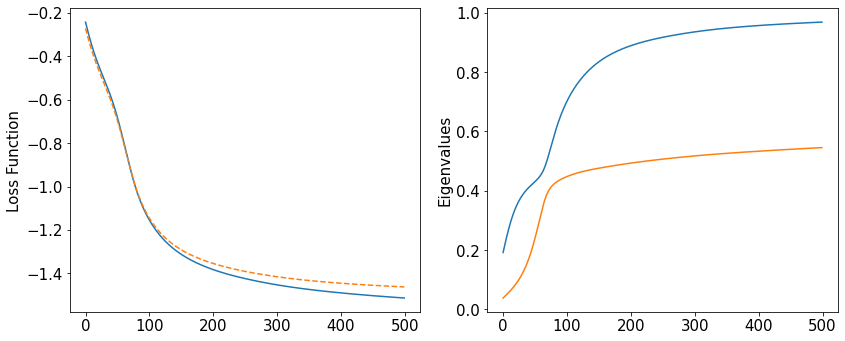

In [13]:
plot_model_lossfunction(model)

Text(0, 0.5, '$\\psi$')

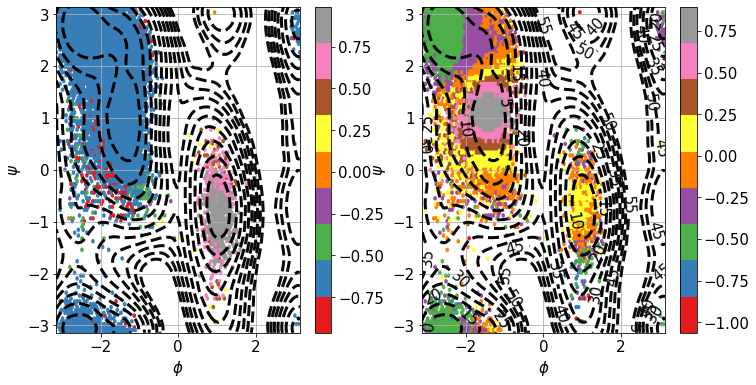

In [14]:
# plot cvs #
colvar["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
colvar["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]   

fig,ax = plt.subplots(1,2,figsize=(12,6))
colvar.plot.hexbin(y="psi",x="phi",C="cv1",cmap="Set1",ax=ax[0])
colvar.plot.hexbin(y="psi",x="phi",C="cv2",cmap="Set1",ax=ax[1])

fes = np.loadtxt("angles/fes.txt",delimiter=" ")
grid0 = np.loadtxt("angles/grid0.txt",delimiter=" ")
grid1 = np.loadtxt("angles/grid1.txt",delimiter=" ")
bounds = np.arange(0, 60, 5.)
c = ax[0].contour(grid0, grid1, fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
)
c = ax[1].contour(grid0, grid1, fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
)
c.clabel()
ax[0].grid()
ax[0].set_xlabel(r"$\phi$")
ax[0].set_ylabel(r"$\psi$")
ax[1].grid()
ax[1].set_xlabel(r"$\phi$")
ax[1].set_ylabel(r"$\psi$")

Text(0, 0.5, '$\\psi$')

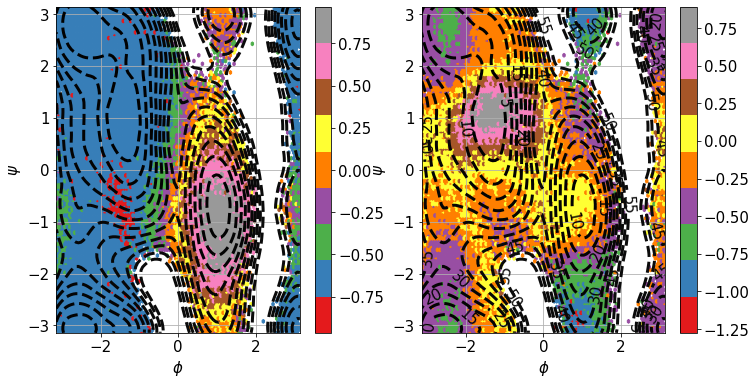

In [15]:
# plot cvs in benchmark space #
data_complete = load_dataframe("angles/COLVAR")
X_complete = data_complete[descriptors_names].to_numpy() 
data_complete["cv1"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[0]
data_complete["cv2"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[1]

fig,ax = plt.subplots(1,2,figsize=(12,6))
data_complete.plot.hexbin(y="psi",x="phi",C="cv1",cmap="Set1",ax=ax[0])
data_complete.plot.hexbin(y="psi",x="phi",C="cv2",cmap="Set1",ax=ax[1])

fes = np.loadtxt("angles/fes.txt",delimiter=" ")
grid0 = np.loadtxt("angles/grid0.txt",delimiter=" ")
grid1 = np.loadtxt("angles/grid1.txt",delimiter=" ")
bounds = np.arange(0, 60, 5.)
c = ax[0].contour(grid0, grid1, fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
)
c = ax[1].contour(grid0, grid1, fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
)
c.clabel()
ax[0].grid()
ax[0].set_xlabel(r"$\phi$")
ax[0].set_ylabel(r"$\psi$")
ax[1].grid()
ax[1].set_xlabel(r"$\phi$")
ax[1].set_ylabel(r"$\psi$")